# Clinical task generation

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string
from random import shuffle,seed,choices
from faker import Faker
from faker.providers.person.en import Provider
import networkx as nx
import itertools

from utils import Utils
from clinical_notes import TaskGenerator,DataSetGenerator

In [2]:
u = Utils()
dg = DataSetGenerator()

## Helper functions

In [3]:
def get_pns_ate(df, 
                verbose = True,
                return_value: str = "pns"):
    
    pns = u.get_pns_direct(df, 
                           y_do_x1 = "True (cause = True)", 
                           y_do_x0 = "True (cause = False)")
    ate = u.get_ate(df,
                    y_do_x1 = "True (cause = True)", 
                    y_do_x0 = "True (cause = False)")
    if verbose:
        print("PNS =", pns)
        print("ATE =", ate)
        
    if return_value == "pns":
        return pns
    elif return_value == "ate":
        return ate
    else:
        return pns,ate

## Error test (low complexity)

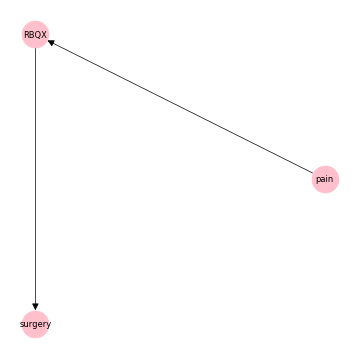


Context: Chronic disease QELE4K sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 7/10) if they carry allele 5G7Q, a genetic marker for severe QELE4K. If the patient self-reports significant pain or the patient has a family history of 3UJV, then vital RBQX will be low (less than 0.15 mg/dL). If RBQX is low and the patient has a family history of HSI3, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.

Patient history: Now, we will review the history and physical notes for patient Kenneth Soto. History of Present Illness: Kenneth Soto is a 57-year-old male with QELE4K who presented to the emergency department with acute onset pain that began 5 hours prior to arrival. Pain was rated 3/10. The patient reports the pain has been persistent since onset. The patient took aspirin (250 mg) at 

In [4]:
size = [2,2]
tg = TaskGenerator(n_per_bcc = size, 
                   bcc_types = ["cycle"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_patient_history(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [5]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Given these history and physical notes, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 0, 'RBQX': 1, 'surgery': 0},
  'True exogenous': {'5G7Q': 0, '3UJV': 1, 'HSI3': 0},
  'True response': 0},
 'RBQX': {'Prompt': 'Given these history and physical notes, will vital RBQX be low? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 0, 'RBQX': 1, 'surgery': 0},
  'True exogenous': {'5G7Q': 0, '3UJV': 1, 'HSI3': 0},
  'True response': 1}}

In [6]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, 'RBQX': 1, 'surgery': 0}
True exogenous: {'5G7Q': 0, '3UJV': 1, 'HSI3': 0}
True response: 0

-----------------------

-- ('pain', 'RBQX') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will vital RBQX be low? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, 'RBQX': 1, 'surgery': 0}
True exogenous: {'5G7Q': 0, '3UJV': 1, 'HSI3': 0}
True response: 1

-----------------------

-- ('RBQX', 'surgery') --
Prompt: Now suppose that vital RBQX will be low regardless of all other circumstances. With this new assumption,

In [7]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, 'RBQX': 1, 'surgery': 0}
True exogenous: {'5G7Q': 0, '3UJV': 1, 'HSI3': 0}
True response: 0

-----------------------

-- ('pain', 'RBQX') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will vital RBQX be low? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, 'RBQX': 1, 'surgery': 0}
True exogenous: {'5G7Q': 0, '3UJV': 1, 'HSI3': 0}
True response: 1

-----------------------

-- ('RBQX', 'surgery') --
Prompt: Now suppose that vital RBQX will not be low regardless of all other circumstances. With this new assumption, will the s

In [8]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,RBQX,surgery
0,1,1,0
1,1,1,1
2,0,1,1
3,0,0,0
4,0,0,0


,5G7Q,3UJV,HSI3
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1


In [9]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- pain = 1 --


,pain,RBQX,surgery
0,1,1,0
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


,5G7Q,3UJV,HSI3
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1



-- RBQX = 1 --


,pain,RBQX,surgery
0,1,1,0
1,1,1,1
2,0,1,1
3,0,1,1
4,0,1,1


,5G7Q,3UJV,HSI3
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1


In [10]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- pain = 0 --


,pain,RBQX,surgery
0,0,0,0
1,0,1,1
2,0,1,1
3,0,0,0
4,0,0,0


,5G7Q,3UJV,HSI3
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1



-- RBQX = 0 --


,pain,RBQX,surgery
0,1,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0


,5G7Q,3UJV,HSI3
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1


## Error test (moderate complexity)

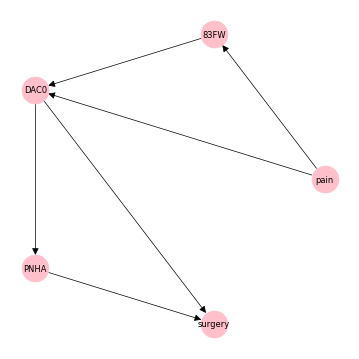


Context: Chronic disease BPHNUM sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 9/10) if they carry allele RG0H, a genetic marker for severe BPHNUM. If the patient self-reports significant pain or the patient has a family history of LZR3, then vital 83FW will be low (less than 0.83 mg/dL). If the patient self-reports significant pain or 83FW is low or the patient carries allele 3XRP, then vital DAC0 will be elevated (greater than 2.81 mg/dL). If DAC0 is elevated or the patient carries allele G9R7, then lab PNHA will be elevated (greater than 2.39 mg/dL). If DAC0 is elevated and PNHA is elevated and the patient has previously received surgery for SI4D, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.

Patient history: Now, we will review the history and physical notes for patient De

In [11]:
size = [3,3]
tg = TaskGenerator(n_per_bcc = size, 
                   bcc_types = ["cycle"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_patient_history(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [12]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Given these history and physical notes, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 0,
   '83FW': 0,
   'DAC0': 1,
   'PNHA': 1,
   'surgery': 1},
  'True exogenous': {'RG0H': 0, 'LZR3': 0, '3XRP': 1, 'G9R7': 0, 'SI4D': 1},
  'True response': 1},
 'DAC0': {'Prompt': 'Given these history and physical notes, will vital DAC0 be elevated? Begin your response with Yes or No and be as concise as possible.',
  'True endogenous': {'pain': 0,
   '83FW': 0,
   'DAC0': 1,
   'PNHA': 1,
   'surgery': 1},
  'True exogenous': {'RG0H': 0, 'LZR3': 0, '3XRP': 1, 'G9R7': 0, 'SI4D': 1},
  'True response': 1}}

In [13]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, '83FW': 1, 'DAC0': 1, 'PNHA': 1, 'surgery': 1}
True exogenous: {'RG0H': 0, 'LZR3': 0, '3XRP': 1, 'G9R7': 0, 'SI4D': 1}
True response: 1

-----------------------

-- ('pain', 'DAC0') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will vital DAC0 be elevated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 1, '83FW': 1, 'DAC0': 1, 'PNHA': 1, 'surgery': 1}
True exogenous: {'RG0H': 0, 'LZR3': 0, '3XRP': 1, 'G9R7': 0, 'SI4D': 1}
True response: 1

-----------------------

-- ('DAC0', 'surgery') --
Prompt: Now suppose

In [14]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, '83FW': 0, 'DAC0': 1, 'PNHA': 1, 'surgery': 1}
True exogenous: {'RG0H': 0, 'LZR3': 0, '3XRP': 1, 'G9R7': 0, 'SI4D': 1}
True response: 1

-----------------------

-- ('pain', 'DAC0') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will vital DAC0 be elevated? Begin your response with Yes or No and be as concise as possible.
True endogenous: {'pain': 0, '83FW': 0, 'DAC0': 1, 'PNHA': 1, 'surgery': 1}
True exogenous: {'RG0H': 0, 'LZR3': 0, '3XRP': 1, 'G9R7': 0, 'SI4D': 1}
True response: 1

-----------------------

-- ('DAC0', 'surgery') --
Prompt: Now suppose that vital DAC

In [15]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,83FW,DAC0,PNHA,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,RG0H,LZR3,3XRP,G9R7,SI4D
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0


In [16]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- DAC0 = 1 --


,pain,83FW,DAC0,PNHA,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,RG0H,LZR3,3XRP,G9R7,SI4D
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0



-- pain = 1 --


,pain,83FW,DAC0,PNHA,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,1,1,1,1,1
3,1,1,1,1,0
4,1,1,1,1,0


,RG0H,LZR3,3XRP,G9R7,SI4D
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0


In [17]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- DAC0 = 0 --


,pain,83FW,DAC0,PNHA,surgery
0,1,1,0,1,0
1,1,1,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,0,1,0


,RG0H,LZR3,3XRP,G9R7,SI4D
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0



-- pain = 0 --


,pain,83FW,DAC0,PNHA,surgery
0,0,0,0,1,0
1,0,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,RG0H,LZR3,3XRP,G9R7,SI4D
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0


In [18]:
glo = [tg.get_global()]
loc = tg.get_local()
comp = tg.get_compositions()

print(glo)
print(loc)
print(comp)

[('pain', 'surgery')]
[('pain', 'DAC0'), ('DAC0', 'surgery')]
[[('pain', 'DAC0'), ('DAC0', 'surgery')]]


In [19]:
# Get PNS and compare to ATE.
results_dict = dict()
for n in [5,10,50,100,500,1000,5000]:
    pair_dict = dict()
    for pair in glo+loc:
        df_cf, df_noise = tg.sample_scm(n = n,
                                        intervene_node = pair[0],
                                        intervene_value = 1)
        df_cf.rename(columns={pair[1]: 'True (cause = True)'}, inplace = True)
        df_cf_0, df_noise = tg.sample_scm(n = n,
                                          intervene_node = pair[0],
                                          intervene_value = 0)
        df_cf["True (cause = False)"] = df_cf_0[pair[1]]
        display(df_cf.head(5))
        print("\n-- {} | n = {} --".format(pair,n))
        pns = get_pns_ate(df_cf)
        pair_dict[pair] = pns
    results_dict[n] = pair_dict

,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 5 --
PNS = 0.0
ATE = 0.0


,pain,83FW,True (cause = True),PNHA,surgery,True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,1
4,1,1,1,1,0,1



-- ('pain', 'DAC0') | n = 5 --
PNS = 0.2
ATE = 0.19999999999999996


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,0,1,1,0,0
4,0,0,1,1,0,0



-- ('DAC0', 'surgery') | n = 5 --
PNS = 0.2
ATE = 0.2


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 10 --
PNS = 0.0
ATE = 0.0


,pain,83FW,True (cause = True),PNHA,surgery,True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1



-- ('pain', 'DAC0') | n = 10 --
PNS = 0.1
ATE = 0.09999999999999998


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,1,1,1,1,0
4,0,1,1,1,1,0



-- ('DAC0', 'surgery') | n = 10 --
PNS = 0.6
ATE = 0.6


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,1
2,1,1,1,1,0,0
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 50 --
PNS = 0.06
ATE = 0.06


,pain,83FW,True (cause = True),PNHA,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,1,1
2,1,1,1,1,0,1
3,1,1,1,1,0,1
4,1,1,1,1,1,1



-- ('pain', 'DAC0') | n = 50 --
PNS = 0.18
ATE = 0.18000000000000005


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,0,1,1,1,0,0
3,0,1,1,1,0,0
4,0,0,1,1,1,0



-- ('DAC0', 'surgery') | n = 50 --
PNS = 0.52
ATE = 0.52


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 100 --
PNS = 0.13
ATE = 0.13


,pain,83FW,True (cause = True),PNHA,surgery,True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,1
4,1,1,1,1,1,1



-- ('pain', 'DAC0') | n = 100 --
PNS = 0.26
ATE = 0.26


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,1,1,1,0,0
4,0,1,1,1,1,0



-- ('DAC0', 'surgery') | n = 100 --
PNS = 0.51
ATE = 0.51


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 500 --
PNS = 0.138
ATE = 0.138


,pain,83FW,True (cause = True),PNHA,surgery,True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'DAC0') | n = 500 --
PNS = 0.25
ATE = 0.25


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,0,1,1,0,0
4,0,1,1,1,1,0



-- ('DAC0', 'surgery') | n = 500 --
PNS = 0.512
ATE = 0.512


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,1,1,1,1,0,0
3,1,1,1,1,1,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 1000 --
PNS = 0.12
ATE = 0.12


,pain,83FW,True (cause = True),PNHA,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,1,0
2,1,1,1,1,0,1
3,1,1,1,1,1,0
4,1,1,1,1,0,1



-- ('pain', 'DAC0') | n = 1000 --
PNS = 0.251
ATE = 0.251


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,0,0,1,1,0,0
3,0,0,1,1,1,0
4,0,1,1,1,0,0



-- ('DAC0', 'surgery') | n = 1000 --
PNS = 0.492
ATE = 0.492


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,0
3,1,1,1,1,0,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 5000 --
PNS = 0.123
ATE = 0.123


,pain,83FW,True (cause = True),PNHA,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,1,0
3,1,1,1,1,0,1
4,1,1,1,1,0,1



-- ('pain', 'DAC0') | n = 5000 --
PNS = 0.2456
ATE = 0.24560000000000004


,pain,83FW,DAC0,PNHA,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,0,1,1,1,0
3,0,1,1,1,0,0
4,0,1,1,1,0,0



-- ('DAC0', 'surgery') | n = 5000 --
PNS = 0.4914
ATE = 0.4914


In [20]:
for n,res in results_dict.items():
    print("\n-- n = {} --".format(n))
    comp_pns = 1
    for pair,pns in res.items():
        if pair == glo[0]:
            global_pns = pns
        else:
            comp_pns *= pns
    print("Global PNS  =", global_pns)
    print("Composition =", comp_pns)


-- n = 5 --
Global PNS  = 0.0
Composition = 0.04000000000000001

-- n = 10 --
Global PNS  = 0.0
Composition = 0.06

-- n = 50 --
Global PNS  = 0.06
Composition = 0.0936

-- n = 100 --
Global PNS  = 0.13
Composition = 0.1326

-- n = 500 --
Global PNS  = 0.138
Composition = 0.128

-- n = 1000 --
Global PNS  = 0.12
Composition = 0.123492

-- n = 5000 --
Global PNS  = 0.123
Composition = 0.12068784


In [21]:
results_dict

{5: {('pain', 'surgery'): 0.0,
  ('pain', 'DAC0'): 0.2,
  ('DAC0', 'surgery'): 0.2},
 10: {('pain', 'surgery'): 0.0,
  ('pain', 'DAC0'): 0.1,
  ('DAC0', 'surgery'): 0.6},
 50: {('pain', 'surgery'): 0.06,
  ('pain', 'DAC0'): 0.18,
  ('DAC0', 'surgery'): 0.52},
 100: {('pain', 'surgery'): 0.13,
  ('pain', 'DAC0'): 0.26,
  ('DAC0', 'surgery'): 0.51},
 500: {('pain', 'surgery'): 0.138,
  ('pain', 'DAC0'): 0.25,
  ('DAC0', 'surgery'): 0.512},
 1000: {('pain', 'surgery'): 0.12,
  ('pain', 'DAC0'): 0.251,
  ('DAC0', 'surgery'): 0.492},
 5000: {('pain', 'surgery'): 0.123,
  ('pain', 'DAC0'): 0.2456,
  ('DAC0', 'surgery'): 0.4914}}

## Error test (high complexity)

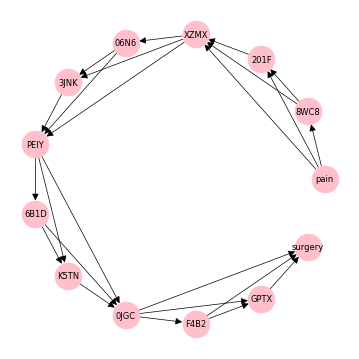


Context: Chronic disease FA72ZQ sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 7/10) if they carry allele 95CS, a genetic marker for severe FA72ZQ. If the patient self-reports significant pain or the patient carries allele 2LJS, then lab 8WC8 will be elevated (greater than 3.36 mg/dL). If the patient self-reports significant pain or 8WC8 is elevated or the patient has previously received surgery for ZBZS, then vital 201F will be low (less than 2.48 mg/dL). If the patient self-reports significant pain or 8WC8 is elevated or 201F is low or the patient has a family history of CXVQ, then vital XZMX will be low (less than 3.1 mg/dL). If XZMX is low or the patient has previously received surgery for AAYQ, then vital 06N6 will be low (less than 0.75 mg/dL). If XZMX is low or 06N6 is low or the patient has a family history of NQD5, then lab 3JNK will be

In [22]:
size = [4,4,4,4]
tg = TaskGenerator(n_per_bcc = size, 
                   bcc_types = ["wheel"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_patient_history(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [23]:
print(tg.exog_names)
print(tg.exog_true_binary)
print(tg.alleles_obs)
print(tg.fam_hist_obs)
print(tg.prev_surg_obs)

['95CS', '2LJS', 'ZBZS', 'CXVQ', 'AAYQ', 'NQD5', 'M2V4', 'VWQ3', 'ISPF', 'I76Y', '0TTE', 'AF45', 'O2N3']
[0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0]
['ISPF', 'I76Y', '0TTE']
[]
['ZBZS', 'VWQ3', 'AF45']


## Generate dataset

In [24]:
# x levels of graphical complexity (captured by BCC size).
# y tasks per graphical complexity level.
# z samples per task.
# = x*y*z subtasks.
graph_sizes = [[2,2],[3,3],[4,4]]
n_tasks_per_size = 3
n_samples_per_task = 1000

df = dg.get_dataset(graph_sizes = graph_sizes,
                    n_tasks_per_size = n_tasks_per_size,
                    n_samples_per_task = n_samples_per_task)

display(df)

,Task ID,Context ID,Sample ID,Nodes per BCC,DAG adjacency matrix,DAG nodes,CCT adjacency matrix,CCT nodes,Exogenous variables,Bernoulli parameters,Global quantity,Local quantities,Compositions,Causal context,Patient history,Factual queries,Counterfactual queries (cause = True),Counterfactual queries (cause = False)
0,0.0,0,0,"[2, 2]","[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, PA4E, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, PA4E, surgery]","[Z42N, K4ZE, VOD5]","[0.5, 0.5, 0.5]","(pain, surgery)","[(pain, PA4E), (PA4E, surgery)]","[[(pain, PA4E), (PA4E, surgery)]]",Chronic disease QS9NBL sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
1,0.1,0,1,"[2, 2]","[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, PA4E, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, PA4E, surgery]","[Z42N, K4ZE, VOD5]","[0.5, 0.5, 0.5]","(pain, surgery)","[(pain, PA4E), (PA4E, surgery)]","[[(pain, PA4E), (PA4E, surgery)]]",Chronic disease QS9NBL sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
2,0.2,0,2,"[2, 2]","[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, PA4E, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, PA4E, surgery]","[Z42N, K4ZE, VOD5]","[0.5, 0.5, 0.5]","(pain, surgery)","[(pain, PA4E), (PA4E, surgery)]","[[(pain, PA4E), (PA4E, surgery)]]",Chronic disease QS9NBL sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
3,0.3,0,3,"[2, 2]","[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, PA4E, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, PA4E, surgery]","[Z42N, K4ZE, VOD5]","[0.5, 0.5, 0.5]","(pain, surgery)","[(pain, PA4E), (PA4E, surgery)]","[[(pain, PA4E), (PA4E, surgery)]]",Chronic disease QS9NBL sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
4,0.4,0,4,"[2, 2]","[[0, 1, 0], [0, 0, 1], [0, 0, 0]]","[pain, PA4E, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, PA4E, surgery]","[Z42N, K4ZE, VOD5]","[0.5, 0.5, 0.5]","(pain, surgery)","[(pain, PA4E), (PA4E, surgery)]","[[(pain, PA4E), (PA4E, surgery)]]",Chronic disease QS9NBL sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,8.995,8,995,"[4, 4]","[[0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[pain, DMQT, YGHG, S22Z, IK12, EXZW, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, S22Z, surgery]","[TZSZ, 6Z30, UIXI, JO70, NH28, CA6I, 6OIR]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]","(pain, surgery)","[(pain, S22Z), (S22Z, surgery)]","[[(pain, S22Z), (S22Z, surgery)]]",Chronic disease X56NF7 sometimes requires surg...,"Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
8996,8.996,8,996,"[4, 4]","[[0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0, 0],...","[pain, DMQT, YGHG, S22Z, IK12, EXZW, surgery]","[[0.0, 1.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, ...","[pain, S22Z, surgery]","[TZSZ, 6Z30, UIXI, JO70, NH28, CA6I, 6OIR]","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]","(p

In [25]:
# Process prompts.
df_factual, df_cf = dg.process_prompts()
display(df_factual)
display(df_cf)

,Task ID,Context ID,Sample ID,Nodes per BCC,Effect,Prompt,True
0,0.0,0,0,"[2, 2]",surgery,Chronic disease QS9NBL sometimes requires surg...,0
1,0.0,0,0,"[2, 2]",PA4E,Chronic disease QS9NBL sometimes requires surg...,1
2,0.1,0,1,"[2, 2]",surgery,Chronic disease QS9NBL sometimes requires surg...,1
3,0.1,0,1,"[2, 2]",PA4E,Chronic disease QS9NBL sometimes requires surg...,1
4,0.2,0,2,"[2, 2]",surgery,Chronic disease QS9NBL sometimes requires surg...,0
...,...,...,...,...,...,...,...
17995,8.997,8,997,"[4, 4]",S22Z,Chronic disease X56NF7 sometimes requires surg...,1
17996,8.998,8,998,"[4, 4]",surgery,Chronic disease X56NF7 sometimes requires surg...,0
17997,8.998,8,998,"[4, 4]",S22Z,Chronic disease X56NF7 sometimes requires surg...,1
17998,8.999,8,999,"[4, 4]",surgery,Chronic disease X56NF7 sometimes requires surg...,1


,Task ID,Context ID,Sample ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)
0,0.0,0,0,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
1,0.0,0,0,"[2, 2]","(pain, PA4E)",pain,PA4E,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,0
2,0.0,0,0,"[2, 2]","(PA4E, surgery)",PA4E,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
3,0.1,0,1,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,1
4,0.1,0,1,"[2, 2]","(pain, PA4E)",pain,PA4E,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,1
...,...,...,...,...,...,...,...,...,...,...,...
26995,8.998,8,998,"[4, 4]","(pain, S22Z)",pain,S22Z,Chronic disease X56NF7 sometimes requires surg...,1,Chronic disease X56NF7 sometimes requires surg...,1
26996,8.998,8,998,"[4, 4]","(S22Z, surgery)",S22Z,surgery,Chronic disease X56NF7 sometimes requires surg...,0,Chronic disease X56NF7 sometimes requires surg...,0
26997,8.999,8,999,"[4, 4]","(pain, surgery)",pain,surgery,Chronic disease X56NF7 sometimes requires surg...,1,Chronic disease X56NF7 sometimes requires surg...,1
26998,8.999,8,999,"[4, 4]","(pain, S22Z)",pain,S22Z,Chronic disease X56NF7 sometimes requires surg...,1,Chronic disease X56NF7 sometimes requires surg...,1


In [26]:
pns_dict = dg.get_pns_dict(verbose = True)
pns_dict

-- PNS = 0.256 | ATE = 0.256 --
-- PNS = 0.49 | ATE = 0.49 --
-- PNS = 0.508 | ATE = 0.508 --
-- PNS = 0.219 | ATE = 0.21899999999999997 --
-- PNS = 0.483 | ATE = 0.483 --
-- PNS = 0.481 | ATE = 0.481 --
-- PNS = 0.228 | ATE = 0.22799999999999998 --
-- PNS = 0.481 | ATE = 0.481 --
-- PNS = 0.494 | ATE = 0.494 --
-- PNS = 0.136 | ATE = 0.136 --
-- PNS = 0.258 | ATE = 0.258 --
-- PNS = 0.491 | ATE = 0.491 --
-- PNS = 0.128 | ATE = 0.128 --
-- PNS = 0.251 | ATE = 0.251 --
-- PNS = 0.505 | ATE = 0.505 --
-- PNS = 0.121 | ATE = 0.121 --
-- PNS = 0.238 | ATE = 0.238 --
-- PNS = 0.506 | ATE = 0.506 --
-- PNS = 0.065 | ATE = 0.065 --
-- PNS = 0.134 | ATE = 0.134 --
-- PNS = 0.506 | ATE = 0.506 --
-- PNS = 0.057 | ATE = 0.056999999999999995 --
-- PNS = 0.12 | ATE = 0.12 --
-- PNS = 0.494 | ATE = 0.494 --
-- PNS = 0.056 | ATE = 0.055999999999999994 --
-- PNS = 0.113 | ATE = 0.11299999999999999 --
-- PNS = 0.487 | ATE = 0.487 --


{0: {"('pain', 'surgery')": 0.256,
  "('pain', 'PA4E')": 0.49,
  "('PA4E', 'surgery')": 0.508,
  "[('pain', 'PA4E'), ('PA4E', 'surgery')]": 0.24892},
 1: {"('pain', 'surgery')": 0.219,
  "('pain', '20N4')": 0.483,
  "('20N4', 'surgery')": 0.481,
  "[('pain', '20N4'), ('20N4', 'surgery')]": 0.23232299999999997},
 2: {"('pain', 'surgery')": 0.228,
  "('pain', 'OBEJ')": 0.481,
  "('OBEJ', 'surgery')": 0.494,
  "[('pain', 'OBEJ'), ('OBEJ', 'surgery')]": 0.237614},
 3: {"('pain', 'surgery')": 0.136,
  "('pain', 'L58S')": 0.258,
  "('L58S', 'surgery')": 0.491,
  "[('pain', 'L58S'), ('L58S', 'surgery')]": 0.126678},
 4: {"('pain', 'surgery')": 0.128,
  "('pain', '77WH')": 0.251,
  "('77WH', 'surgery')": 0.505,
  "[('pain', '77WH'), ('77WH', 'surgery')]": 0.126755},
 5: {"('pain', 'surgery')": 0.121,
  "('pain', '5CSW')": 0.238,
  "('5CSW', 'surgery')": 0.506,
  "[('pain', '5CSW'), ('5CSW', 'surgery')]": 0.120428},
 6: {"('pain', 'surgery')": 0.065,
  "('pain', 'RA5S')": 0.134,
  "('RA5S', 'su

In [28]:
threshold_dict = dg.get_internal_consistency_thresholds(multiplier = 2.0)
threshold_dict

{0: {"[('pain', 'PA4E'), ('PA4E', 'surgery')]": 0.05531250000000002},
 1: {"[('pain', '20N4'), ('20N4', 'surgery')]": 0.12167123287671208},
 2: {"[('pain', 'OBEJ'), ('OBEJ', 'surgery')]": 0.08433333333333319},
 3: {"[('pain', 'L58S'), ('L58S', 'surgery')]": 0.1370882352941176},
 4: {"[('pain', '77WH'), ('77WH', 'surgery')]": 0.01945312499999994},
 5: {"[('pain', '5CSW'), ('5CSW', 'surgery')]": 0.009454545454545505},
 6: {"[('pain', 'RA5S'), ('RA5S', 'surgery')]": 0.0862769230769231},
 7: {"[('pain', 'QVMM'), ('QVMM', 'surgery')]": 0.0799999999999999},
 8: {"[('pain', 'S22Z'), ('S22Z', 'surgery')]": 0.034607142857142774}}

In [29]:
df_cf[df_cf["Context ID"] == 0]

,Task ID,Context ID,Sample ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)
0,0.0,0,0,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
1,0.0,0,0,"[2, 2]","(pain, PA4E)",pain,PA4E,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,0
2,0.0,0,0,"[2, 2]","(PA4E, surgery)",PA4E,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
3,0.1,0,1,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,1
4,0.1,0,1,"[2, 2]","(pain, PA4E)",pain,PA4E,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,1
...,...,...,...,...,...,...,...,...,...,...,...
2995,0.998,0,998,"[2, 2]","(pain, PA4E)",pain,PA4E,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,0
2996,0.998,0,998,"[2, 2]","(PA4E, surgery)",PA4E,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
2997,0.999,0,999,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,0
2998,0.999,0,999,"[2, 2]","(pain, PA4E)",pain,PA4E,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,0


In [30]:
df_cf[(df_cf["Context ID"] == 0) & (df_cf["Cause-effect pair"] == ("pain", "surgery"))]

,Task ID,Context ID,Sample ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)
0,0.0,0,0,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
3,0.1,0,1,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,1
6,0.2,0,2,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
9,0.3,0,3,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
12,0.4,0,4,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
...,...,...,...,...,...,...,...,...,...,...,...
2985,0.995,0,995,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,1,Chronic disease QS9NBL sometimes requires surg...,0
2988,0.996,0,996,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
2991,0.997,0,997,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0
2994,0.998,0,998,"[2, 2]","(pain, surgery)",pain,surgery,Chronic disease QS9NBL sometimes requires surg...,0,Chronic disease QS9NBL sometimes requires surg...,0


In [31]:
df_cf[(df_cf["Context ID"] == 0) & (df_cf["Cause-effect pair"] == ("pain", "HUE3"))]

,Task ID,Context ID,Sample ID,Nodes per BCC,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)


## End of document